A continuación se encuentra un ejemplo práctico del uso de Deep Learning, utilizando Keras y Tensorflow.

---


## Predicción de series ordenadas en el tiempo

En este proyecto se hará una predicción de una serie ordenada en el tiempo usando un regresor RNN (Recurrent Neural Network regressor).

Se hará una predicción del precio de la acción de Apple con 7 días de anticipación, en base a una serie histórica.

Se hará uso de una arquitectura para el RNN conocida como [Long Term Short Memory (LTSM)](https://en.wikipedia.org/wiki/Long_short-term_memory).

### Parte 1: Primeros pasos
Primero se debe cargar una serie histórica. Cargaremos una serie con el precio de la acción de Apple de 140 días. Luego se hará un pre-procesamiento para utilizar la información con un modelo de una RNN. Como primer paso se normalizó el rango la serie. Esto ayuda a evitar grandes problemas numéricos asociados a como las funciones de activación como tanh transforman números muy grandes (sean positivos o negativos) y ayuda a evitar problemas con el cálculo de las derivadas.

Se normaliza la serie para que pertenezca al rango [-1,1] [usando esta función de la librería scikit](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html). También es común ver aplicaciones donde se normaliza utilizando la desviación estándar.


In [1]:
### Cargar las librerías necesarias para el cargado de los datos y la normalización
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


# Clonar repositorio con los datos en espacio de trabajo
! git clone https://bitbucket.org/botiaio/campusparty_applestock.git

Cloning into 'campusparty_applestock'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (3/3), 1.77 KiB | 1.77 MiB/s, done.


In [2]:
### Cargar los datos normalizados
dataset = np.loadtxt('campusparty_applestock/normalized_apple_prices.csv')

Observemos los datos cargados

Text(0, 0.5, 'serie normalizada')

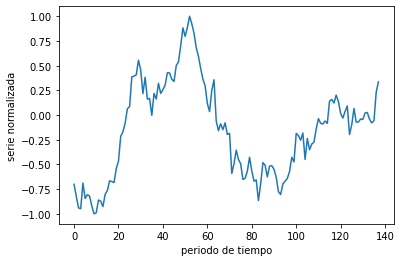

In [3]:
#Grafiquemos los datos
plt.plot(dataset)
plt.xlabel('periodo de tiempo')
plt.ylabel('serie normalizada')

### Parte 2: Cortar la serie ordenada en secuencias

Generalmente se representa matemáticamente una serie ordenada como:

$$s_{0},s_{1},s_{2},...,s_{P}$$


donde $s_{p}$ es el valor numérico de la serie en el intervalo de tiempo $p$ , siendo  $P$ el largo total de la serie. Para aplicar el RNN se debe tratar a la predicción como un problema de regresión. Para ello se debe usar una ventana móvil para construir un set asociado de pares de entrada-salida sobre los cuales aplicar la regresión.

Por ejemplo, para una ventana de tamaño T = 3 se deben producir los siguientes pares:

$$\begin{array}{c|c}
\text{Input} & \text{Output}\\
\hline \color{CornflowerBlue} {\langle s_{1},s_{2},s_{3}\rangle} & \color{Goldenrod}{ s_{4}} \\
\ \color{CornflowerBlue} {\langle s_{2},s_{3},s_{4} \rangle } & \color{Goldenrod} {s_{5} } \\
\color{CornflowerBlue}  {\vdots} & \color{Goldenrod} {\vdots}\\
\color{CornflowerBlue} { \langle s_{P-3},s_{P-2},s_{P-1} \rangle } & \color{Goldenrod} {s_{P}}
\end{array}$$


####Ventana móvil
Completar la función llamada **window_transform_series** que ejecuta una ventana móvil a lo largo de una serie de datos y crea los pares de input y output necesarios para el entrenamiento.

La función recibe la serie de datos y el tamaño de la ventana (3 en el ejemplo de arriba). Se debe retornar un numpy array.

In [4]:
### @TODO: completar la función debajo que transforma los datos en los pares input-output necesarios dado el tamaño de la ventana
def window_transform_series(series,window_size):
    # variables para los pares input-output
    
    # no usé doble for como se mencionaba, me parece más intuitivo así. Se podría vectorizar un paso más incluso.
    X = np.zeros((series.size - window_size, window_size))
    for i in np.arange(0, series.size - window_size):
      X[i,:] = series[i:i+window_size]
    
    y = series[window_size::]
    
        
    # Código auxiliar que puede ser necesario
    # X = np.asarray(X)
    # X.shape = (np.shape(X)[0:2])
    # y = np.asarray(y)
    # y.shape = (len(y),1)
    
    return X,y

Se puede probar la función con los datos de debajo:

### Probar la función window_transform_series
A continuación probar el código recién programado. Puede ser sobre la serie de datos del problema o sobre otra serie de datos cuya secuencia sea conocida (por ejemplo Fibonacci).

In [5]:
test_series = np.arange(10)

In [6]:
### @TODO
# Utilizar una ventana de tamaño 2 y obtener el siguiente número de la serie
window_size = 2
X,y = window_transform_series(test_series, window_size)

In [7]:
print ('El input X es:')
print (X)

print ('El output y asociado es:')
print (y)

El input X es:
[[0. 1.]
 [1. 2.]
 [2. 3.]
 [3. 4.]
 [4. 5.]
 [5. 6.]
 [6. 7.]
 [7. 8.]]
El output y asociado es:
[2 3 4 5 6 7 8 9]


Una vez que la función de arriba funcione correctamente, aplicarla con una ventana de tamaño 7 al juego de datos cargados.



In [8]:
### @TODO
# Definir la variable window_size y usarla al invocar la función window_transform_series
window_size = 7
X,y = window_transform_series(dataset, window_size)

###Parte 3: Separar los datos en datos de entrenamiento y de test
Se recomienda separar al menos un tercio de los datos para validación o test. Hacer eso a continuación. Aprovechar que es una serie ordenada y no hacer un split aleatorio de los datos para separar en test y train.

In [9]:
### @TODO
# Separar los datos en entrenamiento y test
train_test_split = int(len(dataset) * 0.8)

# Partir los datos
X_train = X[0:train_test_split,:]
y_train = y[0:train_test_split]

# Mantener la última parte para test
X_test = X[train_test_split::,:]
y_test = y[train_test_split::]

In [10]:
# IMPORTANTE: para utilizar el módulo RNN LSTM de Keras el input debe tener la forma [samples, window size, stepsize]
#Estas transformaciones se hacen a continuación
X_train = np.asarray(np.reshape(X_train, (X_train.shape[0], window_size, 1)))
X_test = np.asarray(np.reshape(X_test, (X_test.shape[0], window_size, 1)))

###Parte 4: Crear y ejecutar un modelo de regresión utilizando RNN

Se utilizará Keras para construir una red neuronal con dos capas ocultas RNN con las siguientes especificaciones:

* La capa 1 debe usar un módulo LSTM con 5 unidades ocultas (el input_shape de la misma debe ser (window_size,1))
* La capa 2 usa un módulo completamente conectado (fully connected) con una unidad
* Se debe usar la función de pérdida 'mean_squared_error'

Ayudas:

* [Documentación general de Keras](https://keras.io/getting-started/sequential-model-guide/)
* [Documentación de Keras de LTSM](https://keras.io/layers/recurrent/)
* Asegurarse de inicializar el [optimizador recomendado por Keras para RNN](https://keras.io/optimizers/)

In [11]:
### @TODO: Crear el modelo RNN
# Importar librerías de Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import keras

#Crear el modelo secuencial
model = Sequential()
#Agregar una capa LSTM con 5 unidades ocultas y el input shape necesario
model.add(LSTM(5, input_shape=(window_size, 1)))
#Agregar una capa densa con una unidad
model.add(Dense(1))

# Crear el modelo utilizando el optimizador recomendado por la documentación de keras
optimizer = 'adam'

# Compilar el modelo con la función de pérdida requerida
model.compile(loss='mean_squared_error', optimizer=optimizer)

Entrenar el modelo con los datos separados para esta función haciendo uso de la función fit.

Sugerencia: Investigar y probar con distintos valores de epochs y tamaño de batch. Buscar en la documentación de keras por más información.


In [12]:
### @TODO
# Hacer fit
model.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
4/4 [==============================] - 7s 33ms/step - loss: 0.1410
Epoch 2/100
4/4 [==============================] - 0s 14ms/step - loss: 0.1324
Epoch 3/100
4/4 [==============================] - 0s 21ms/step - loss: 0.1239
Epoch 4/100
4/4 [==============================] - 0s 22ms/step - loss: 0.1160
Epoch 5/100
4/4 [==============================] - 0s 24ms/step - loss: 0.1089
Epoch 6/100
4/4 [==============================] - 0s 21ms/step - loss: 0.1018
Epoch 7/100
4/4 [==============================] - 0s 16ms/step - loss: 0.0953
Epoch 8/100
4/4 [==============================] - 0s 15ms/step - loss: 0.0893
Epoch 9/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0841
Epoch 10/100
4/4 [==============================] - 0s 38ms/step - loss: 0.0785
Epoch 11/100
4/4 [==============================] - 0s 13ms/step - loss: 0.0740
Epoch 12/100
4/4 [==============================] - 0s 15ms/step - loss: 0.0703
Epoch 13/100
4/4 [==============================]

###Parte 5: Medir la performance del modelo
Ahora estamos en condiciones de hacer una predicción

In [13]:
### @TODO
# Hacer la predicción con el modelo entrenado
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

1/1 [==============================] - 0s 43ms/step


Se debería obtener un error sobre los datos de entrenamiento como de test menor al 2%. Si no se consigue este valor, se puede aumentar el número de epochs y re-entrenar el modelo o ajustar el tamaño del batch. Estudiar en la documentación que otros hiper-parámetros se pueden modificar para mejorar la precisión.

In [14]:
# Medir la precisión
training_error = model.evaluate(X_train, y_train, verbose=0)
print('Error de entrenamiento = ' + str(training_error))

testing_error = model.evaluate(X_test, y_test, verbose=0)
print('Error de test = ' + str(testing_error))

Error de entrenamiento = 0.03294985368847847
Error de test = 0.016616106033325195


Ahora grafiquemos los datos:

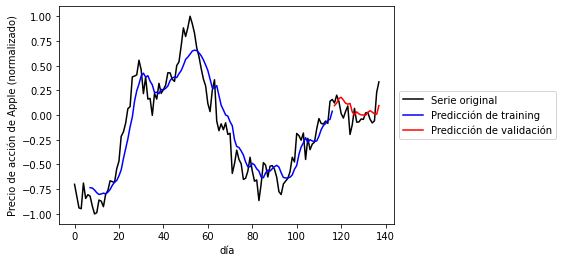

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

# Graficar serie original
plt.plot(dataset,color = 'k')

# Graficar la predicción de entrenamiento
split_pt = train_test_split + window_size 
plt.plot(np.arange(window_size,split_pt,1),train_predict,color = 'b')

# Graficar la predicción de validación
plt.plot(np.arange(split_pt,split_pt + len(test_predict),1),test_predict,color = 'r')

# Agregar rótulos
plt.xlabel('día')
plt.ylabel('Precio de acción de Apple (normalizado)')
plt.legend(['Serie original','Predicción de training','Predicción de validación'],loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Nota:[Aquí](https://datamarket.com/data/list/?q=provider%3Atsdl) se pueden encontrar otras series ordenadas con las que probar

### Puntos de mejora
A continuación listar o llevar adelante los puntos que se entiende pueden mejorar la solución alcanzada.

1) Se podría dividir el dataset en una parte de validación que permita realizar un ajuste de los hiperparámetros como el número de épocas y el batch size. También se podrían considerar otros hiperparámetros como el learning rate, la cantidad de capas, o el número de neuronas

2) Se podría agregar un parámetro de regularización ($\lambda$*norma) para evitar overfitting, o utilizar alguna estrategia de regularización como dropout o similar.

3) Se podría utilizar cross validation, cortando los datos del dataset en distintos batchs y utilizarlos en sucesivos ajustes de hiperparámetros.